# motivating example under assumptions

In [1]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.data import SubColumn
from lib.models import MLP, CCM_res, SubColumnNet
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE, wL2, wL1
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

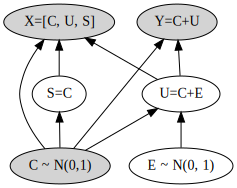

In [2]:
dot = Digraph()

dot.node('X', 'X=[C, U, S]', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('Y', 'Y=C+U', style='filled', fillcolor='lightgray')
dot.node('U', 'U=C+E')
dot.node('E', 'E ~ N(0, 1)')
dot.node('S', 'S=C')
dot.edges(['UY', 'CY', 'CS', 'EU', 'SX', 'CX', 'UX', 'CU'])
# dot.edge('Z', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example')
dot

This case is interesting b/c the problem is linear and U is correlated with S

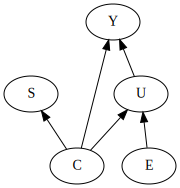

          C         U         S         E         Y
0  1.165237 -0.332505  1.165237 -1.497742  0.832733
1 -0.106905  1.155035 -0.106905  1.261940  1.048130
2 -0.294948  0.922996 -0.294948  1.217944  0.628047
3 -0.467323  0.134712 -0.467323  0.602035 -0.332611
4  0.767679  1.618410  0.767679  0.850731  2.386089
5  0.396752 -2.023122  0.396752 -2.419874 -1.626371
6 -1.588300 -2.121115 -1.588300 -0.532815 -3.709416
7 -1.769966 -1.390542 -1.769966  0.379424 -3.160508
8  0.343818 -0.619838  0.343818 -0.963656 -0.276020
9 -1.932751 -3.841200 -1.932751 -1.908449 -5.773951


,C,U,S,E,Y
0,-0.149179,-0.520593,0.0,-0.371414,-0.669771
1,-0.247225,-0.992700,0.0,-0.745474,-1.239925
2,-0.020610,-1.075121,0.0,-1.054511,-1.095731
3,-0.219255,-0.891214,0.0,-0.671959,-1.110469
4,0.672093,0.498397,0.0,-0.173696,1.170490
5,0.536892,0.728235,0.0,0.191343,1.265126
6,0.058540,1.674765,0.0,1.616225,1.733305
7,0.667273,0.647234,0.0,-0.020040,1.314507
8,-1.458682,-0.660999,0.0,0.797683,-2.119681
9,-0.060299,0.391826,0.0,0.452125,0.331526


In [3]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    e = Node('E')
    s = Node('S', lambda c: c, [c])
    u = Node('U', lambda c, e: c + e, [c, e])
    y  = Node('Y', lambda c, u: c+u,
              [c, u], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u, s, e, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
n = 10
print(sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n)})[['C', 'U', 'S', 'E', 'Y']])
sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'E', 'Y']]

In [4]:
n = 100000
bs = 100
wd = 1e-4

XYC = sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_deploy = sample_graph(graph, {'C': np.random.randn(n), 'E': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U', 'S']])
    Y = np.array(XYC[['Y']])
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).float(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)
r = torch.zeros(d) # concept mask
r[0] = 1

# accuracy
mse_criterion = lambda o, y: F.mse_loss(o, y)

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 654.14it/s]


epoch   0: loss 2.456e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 765.69it/s]


epoch   1: loss 2.187e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 747.75it/s]


epoch   2: loss 4.997e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 669.03it/s]


epoch   3: loss 5.434e-03


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 775.86it/s]


epoch   4: loss 1.527e-04


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 771.69it/s]


epoch   5: loss 5.048e-07


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 747.69it/s]


epoch   6: loss 1.438e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 753.81it/s]


epoch   7: loss 1.254e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 656.40it/s]


epoch   8: loss 1.252e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 608.83it/s]


epoch   9: loss 1.257e-09


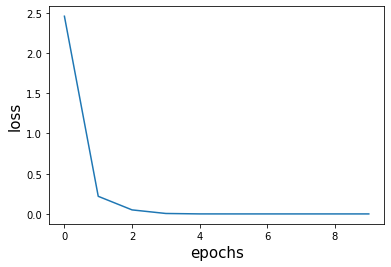

In [5]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([d, 1])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [6]:
# ['C', 'U', 'S']
list(STD.classifier[0].parameters())

[Parameter containing:
 tensor([[0.6717, 1.0000, 0.3283]], requires_grad=True),
 Parameter containing:
 tensor([2.2499e-06], requires_grad=True)]

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 556.48it/s]


epoch   0: loss 3.157e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 667.36it/s]


epoch   1: loss 3.255e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 515.95it/s]


epoch   2: loss 1.170e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 559.11it/s]


epoch   3: loss 6.004e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 633.25it/s]


epoch   4: loss 5.039e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 659.98it/s]


epoch   5: loss 4.911e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 584.96it/s]


epoch   6: loss 4.821e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 598.12it/s]


epoch   7: loss 4.814e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 537.01it/s]


epoch   8: loss 4.814e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 552.89it/s]


epoch   9: loss 4.814e-02


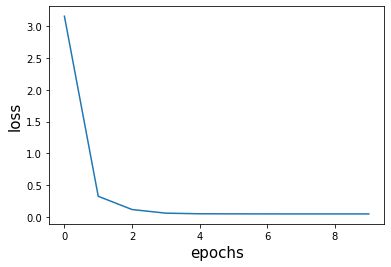

In [7]:
def CCM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([len(r), 1])

    # train
    criterion = lambda o_y, y: F.mse_loss(o_y, y) + 2e-2 * EYE(r, net.classifier[0].weight.abs().sum(0))
    # criterion = lambda o_y, y: F.mse_loss(o_y, y) + 0.05 * wL1(r, net.classifier[0].weight.abs().sum(0))
    # criterion = lambda o_y, y: F.mse_loss(o_y, y) + 0.1 * wL2(r, net.classifier[0].weight.abs().sum(0))

    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 10
ccm = CCM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [8]:
# ['C', 'U', 'S']
list(ccm.classifier[0].parameters())

[Parameter containing:
 tensor([[ 1.0026e+00,  9.9047e-01, -4.2377e-05]], requires_grad=True),
 Parameter containing:
 tensor([0.0002], requires_grad=True)]

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 643.33it/s]


epoch   0: loss 3.030e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 808.43it/s]


epoch   1: loss 1.440e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 811.02it/s]


epoch   2: loss 1.053e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 739.21it/s]


epoch   3: loss 1.005e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 684.08it/s]


epoch   4: loss 1.004e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 923.05it/s]


epoch   5: loss 1.004e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 920.99it/s]


epoch   6: loss 1.004e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 932.53it/s]


epoch   7: loss 1.004e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 937.86it/s]


epoch   8: loss 1.004e+00


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 945.45it/s]


epoch   9: loss 1.004e+00


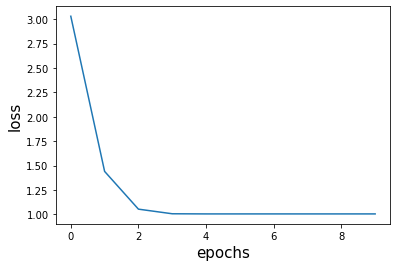

In [9]:
def CBM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = nn.Sequential(SubColumnNet(r.bool()), MLP([int(sum(r).item()), 1]))

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
cbm = CBM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [10]:
list(cbm[1].classifier[0].parameters())

[Parameter containing:
 tensor([[2.0001]], requires_grad=True),
 Parameter containing:
 tensor([-0.0060], requires_grad=True)]

train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 779.02it/s]


epoch   0: loss 9.638e-01


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 719.54it/s]


epoch   1: loss 8.347e-02


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 617.42it/s]


epoch   2: loss 1.430e-03


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 554.00it/s]


epoch   3: loss 1.630e-06


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 694.96it/s]


epoch   4: loss 6.560e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 539.14it/s]


epoch   5: loss 6.211e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 600.75it/s]


epoch   6: loss 6.264e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 703.64it/s]


epoch   7: loss 6.226e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 702.73it/s]


epoch   8: loss 6.263e-09


train step for 1 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 703.87it/s]


epoch   9: loss 6.275e-09


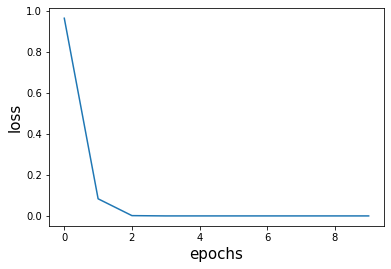

In [11]:
def Res(loader_xy, cbm, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = MLP([d, 1])    
    net = CCM_res(cbm, net)

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    # opt = optim.SGD(net.parameters(), lr=0.01, weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
res = Res(loader_xy, cbm, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [12]:
list(res.net2.classifier[0].parameters())

[Parameter containing:
 tensor([[-0.5348,  0.9999, -0.4652]], requires_grad=True),
 Parameter containing:
 tensor([0.0060], requires_grad=True)]

In [13]:
print('Before distribution shift')
print('task mse EYE after training: {:.1e}'.format(test(ccm, loader_xy_te, mse_criterion)))
print('task mse RES after training: {:.1e}'.format(test(res, loader_xy_te, mse_criterion)))
print('task mse CBM after training: {:.1e}'.format(test(cbm, loader_xy_te, mse_criterion)))
print('task mse STD(X) after training: {:.1e}'.format(test(STD, loader_xy_te, mse_criterion)))

Before distribution shift


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1038.48it/s]


task mse EYE after training: 1.4e-04


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1008.22it/s]


task mse RES after training: 6.5e-09


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1098.88it/s]


task mse CBM after training: 1.0e+00


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1151.32it/s]

task mse STD(X) after training: 1.3e-09


In [14]:
print('After distribution shift')
print('task mse EYE after training: {:.1e}'.format(test(ccm, loader_xy_de, mse_criterion)))
print('task mse RES after training: {:.1e}'.format(test(res, loader_xy_de, mse_criterion)))
print('task mse CBM after training: {:.1e}'.format(test(cbm, loader_xy_de, mse_criterion)))
print('task mse STD(X) after training: {:.1e}'.format(test(STD, loader_xy_de, mse_criterion)))

After distribution shift


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1053.76it/s]


task mse EYE after training: 1.4e-04


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1010.64it/s]


task mse RES after training: 2.2e-01


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1104.81it/s]


task mse CBM after training: 1.0e+00


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1158.08it/s]

task mse STD(X) after training: 1.1e-01
